### Some good test queries in here, including
- Direct BQ SQL Queries
- Direct Queris of views I saved in BQ

In [76]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import datetime as dt
import matplotlib.dates as mdates

print("System: ", sys.version)
print("Numpy:", np.__version__)
print("Pandas:", pd.__version__)

%matplotlib inline

System:  3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08) 
[GCC 7.5.0]
Numpy: 1.18.5
Pandas: 1.1.1


In [44]:
%%capture
!pip install google-cloud-bigquery-storage

Waiting on bqjob_r155b308265366b62_00000174b34191c8_1 ... (2s) Current status: DONE   
+---------+-----------+--------+--------+
| Morning | Afternoon | Other  | Total  |
+---------+-----------+--------+--------+
|  404919 |    176142 | 402587 | 983648 |
+---------+-----------+--------+--------+


In [12]:
! bq query --use_legacy_sql=FALSE 'SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_trips` LIMIT 10'

Waiting on bqjob_r46b00081ce87c4e2_00000174b33b60e9_1 ... (0s) Current status: DONE   
+---------+--------------+---------------------+--------------------+------------------+---------------------+------------------+----------------+-------------+----------+-----------------+
| trip_id | duration_sec |     start_date      | start_station_name | start_station_id |      end_date       | end_station_name | end_station_id | bike_number | zip_code | subscriber_type |
+---------+--------------+---------------------+--------------------+------------------+---------------------+------------------+----------------+-------------+----------+-----------------+
|  944732 |         2618 | 2015-09-24 17:22:00 | Mezes              |               83 | 2015-09-24 18:06:00 | Mezes            |             83 |         653 | 94063    | Customer        |
|  984595 |         5957 | 2015-10-25 18:12:00 | Mezes              |               83 | 2015-10-25 19:51:00 | Mezes            |             83 |       

In [10]:
! bq query --use_legacy_sql=FALSE 'SELECT start_station_name, end_station_name, count(*) as trip_freq FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY start_station_name, end_station_name ORDER BY trip_freq DESC LIMIT 5'

Waiting on bqjob_r73cea82e8bb2f126_00000174b330c76f_1 ... (0s) Current status: DONE   
+-----------------------------------------+--------------------------------------+-----------+
|           start_station_name            |           end_station_name           | trip_freq |
+-----------------------------------------+--------------------------------------+-----------+
| Harry Bridges Plaza (Ferry Building)    | Embarcadero at Sansome               |      9150 |
| San Francisco Caltrain 2 (330 Townsend) | Townsend at 7th                      |      8508 |
| 2nd at Townsend                         | Harry Bridges Plaza (Ferry Building) |      7620 |
| Harry Bridges Plaza (Ferry Building)    | 2nd at Townsend                      |      6888 |
| Embarcadero at Sansome                  | Steuart at Market                    |      6874 |
+-----------------------------------------+--------------------------------------+-----------+


In [ ]:
# This provides # of trips for morning and afternoon

In [19]:
%%bigquery

SELECT
    Morning,
    Afternoon,
    Total - Morning - Afternoon AS Other,
    Total
FROM
    (
    SELECT
        COUNT(trip_id) as Total,
        COUNT(IF( EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(start_date), HOUR)) BETWEEN 5 AND 11, trip_id, NULL)) AS Morning,
        COUNT(IF( EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(start_date), HOUR)) BETWEEN 12 AND 15, trip_id, NULL)) AS Afternoon
    FROM
    `bigquery-public-data.san_francisco.bikeshare_trips`
    ) AS x;


,Morning,Afternoon,Other,Total
0,404919,176142,402587,983648


#### NOTE TO SELF
SAVING VIEWS IN BQ DIDN'T WORK WHEN I TRIED TO RUN A DISTINCT QUERY INSIDE A LARGER FILE
WHEN I PUT THAT SINGLE QUERY INTO A SEPARATE FILE, IT LET ME SAVE THE VIEW
ALSO NOTE, YOU NEED TO CREATE A DATASET INTO WHICH TO INSERT THE TABLE

### Save trips_by_hour to a dataframe in the first cell
Then print that dataframe out in the next

In [20]:
%%bigquery trips_by_hour

SELECT * 
FROM 
    `zinc-hall-287702.Project_1_W205.trip_per_hour`
LIMIT 1000


In [21]:
trips_by_hour

,Hour,trips
0,0,1696
1,1,797
2,2,420
3,3,427
4,4,1273
5,5,4799
6,6,19830
7,7,65900
8,8,128999
9,9,90264


<BarContainer object of 24 artists>

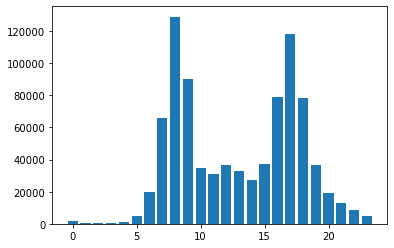

In [38]:
plt.bar(trips_by_hour.Hour, trips_by_hour.trips)

In [ ]:
# This pulls the percentiles of ride duration, w/outliers removed

In [47]:
%%bigquery aframe

SELECT approx_quantiles(duration_sec/60, 100) AS percentiles
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE (duration_sec/60 > 2) AND (duration_sec/3600 < 48)


In [40]:
pct_df = pd.DataFrame(aframe["percentiles"][0])

In [41]:
pct_df.head()

,0
0,2.016667
1,2.516667
2,2.833333
3,3.066667
4,3.250000


### WRITEUP STARTS HERE

- COUNT OF TOTAL TRIPS PER MONTH, FILTERED FOR OUTLIERS IN RIDE DURATION
- ELIMINATE trips <= 2 MINUTES FROM DATA AS THEY'RE MOST LIKELY MISTAKES
- ELIMINATE trips > 48 HOURS AS THEY ARE EITHER EXTREME OUTLIERS OR ERRORS
- DIDN'T MAKE MUCH OF A DIFFERENCE AS THEY'RE A VANISHINGLY SMALL PCT OF TOTAL

In [53]:
%%bigquery monthly_trips

SELECT
    DATE_SUB(DATE_ADD(DATE_TRUNC(DATE(start_date), MONTH),INTERVAL 1 MONTH), INTERVAL 1 DAY) AS Month,
    COUNT(trip_id) AS trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE (duration_sec/60 > 2) AND (duration_sec/3600 < 48) 
GROUP BY 1 
ORDER BY 1

In [ ]:
# Convert string dates to datetime & subset partial month Aug-13 out of dataset
monthly_trips['Month'] = pd.to_datetime(monthly_trips['Month'])
monthly_trips = monthly_trips[ monthly_trips['Month'] > "2013-08-31" ]
monthly_trips.set_index('Month', inplace = True)

In [112]:
#monthly_trips.drop(columns=['pct_12'], inplace = True)

In [114]:
monthly_trips['rolling_12'] = monthly_trips.trips.rolling(12, min_periods=6).mean()


- SUM OF TOTAL TRIP DURATION PER MONTH, MEASURED IN MINUTES
- FILTERED FOR OUTLIERS IN RIDE DURATION
- ELIMINATE trips <= 2 MINUTES FROM DATA AS THEY'RE MOST LIKELY MISTAKES
- ELIMINATE trips > 48 HOURS AS THEY ARE EITHER EXTREME OUTLIERS OR ERRORS
- DIDN'T MAKE MUCH OF A DIFFERENCE AS THEY'RE A VANISHINGLY SMALL PCT OF TOTAL

In [134]:
%%bigquery monthly_duration

SELECT
  DATE_SUB(DATE_ADD(DATE_TRUNC(DATE(start_date), MONTH), INTERVAL 1 MONTH), INTERVAL 1 DAY) AS Month,
  SUM(duration_sec)/60 AS duration_minutes
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE (duration_sec/60 > 2) AND (duration_sec/3600 < 48)
GROUP BY 1 
ORDER BY 1

In [135]:
# Convert string dates to datetime & subset partial month Aug-13 out of dataset
monthly_duration['Month'] = pd.to_datetime(monthly_duration['Month'])
monthly_duration = monthly_duration[ monthly_duration['Month'] > "2013-08-31" ]
monthly_duration.set_index('Month', inplace = True)
monthly_duration['rolling_12'] = monthly_duration.duration_minutes.rolling(12, min_periods=6).mean()

#### The goal of the project is to increase ridership. To that end, we'll start with two measures of ridership.  

#### The first measure is just the number of trips per month.

#### As you can see below, the 12-month moving average, which attempts to adjust for  
#### significant seasonal variation, declined approximately 11% between Aug-2015 and Aug-2016.  
#### Additionally, there's little growth to speak of over the entire time frame.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


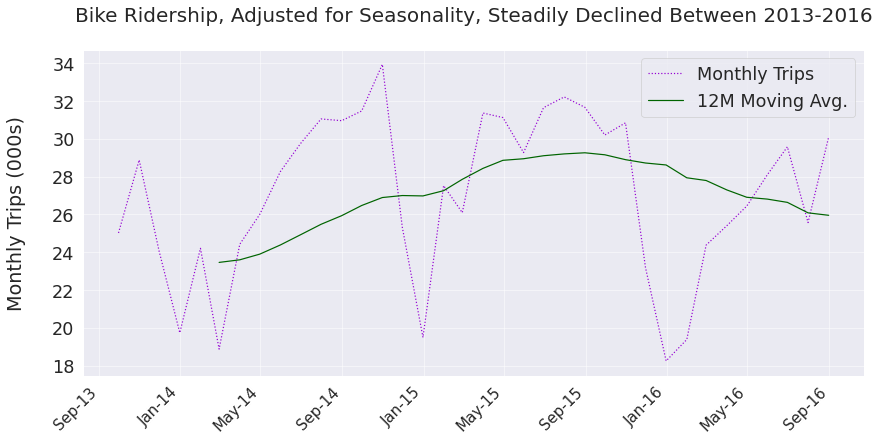

In [128]:

sns.set_context("paper", font_scale = 2, rc={"grid.linewidth": 0.5})
sns.set_style("darkgrid")
fig1, ax1 = plt.subplots(figsize = (14,6))

sns.lineplot(data = monthly_trips.trips/1000, ax = ax1,  color = 'darkviolet', dashes=[':'], label = "Monthly Trips" , legend = False )
sns.lineplot(data = monthly_trips.rolling_12/1000, ax = ax1, color = 'darkgreen',  label = "12M Moving Avg.", legend = False )

ax1.lines[0].set_linestyle(":")

leg = ax1.legend()
ax1.set_ylabel('Monthly Trips (000s)\n')
ax1.set_title("Bike Ridership, Adjusted for Seasonality, Steadily Declined Between 2013-2016\n", size = 20)

fmt = '%b-%y' # Format you want the ticks, e.g. '40%'
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', size = 15)    
ax1.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
leg = ax1.legend()



#### The second measure is the total time spent on bikes. This allows us to 
#### go a little beyond the number of trips and account for actual usage. 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


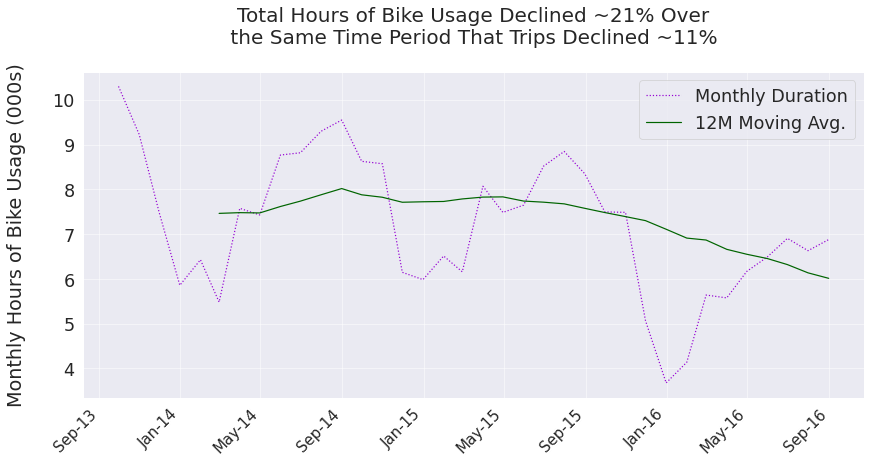

In [150]:

sns.set_context("paper", font_scale = 2, rc={"grid.linewidth": 0.5})
sns.set_style("darkgrid")
fig1, ax1 = plt.subplots(figsize = (14,6))

sns.lineplot(data = monthly_duration.duration_minutes/60000, ax = ax1,  color = 'darkviolet', dashes=[':'], label = "Monthly Duration" , legend = False )
sns.lineplot(data = monthly_duration.rolling_12/60000, ax = ax1, color = 'darkgreen',  label = "12M Moving Avg.", legend = False )

ax1.lines[0].set_linestyle(":")

leg = ax1.legend()
ax1.set_ylabel('Monthly Hours of Bike Usage (000s)\n')
ax1.set_title("Total Hours of Bike Usage Declined ~21% Over\n the Same Time Period That Trips Declined ~11% \n", size = 20)

fmt = '%b-%y' # Format you want the ticks, e.g. '40%'
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', size = 15)    
ax1.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
leg = ax1.legend()
